In [1]:
import tensorflow as tf
import numpy as np
from keras.layers import LSTM, Dense, Dropout, Input
import pandas as pd
from sklearn.model_selection import train_test_split
import datetime
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from sklearn.ensemble import RandomForestClassifier
# import tensorflow_decision_forests as tfdf
import ydf

In [2]:
price_history = pd.read_csv('data/ETH_USD_11_20_2020-1_19_2021_historical_prices.csv', sep=';')
whales = pd.read_csv('data/transactions_aggregated_21_22.csv')
validators = pd.read_csv('data/validators_aggregated_21_22.csv')

# Basic cleaning
whales['date'] = pd.to_datetime(whales['datetime']).dt.date
validators['date'] = pd.to_datetime(validators['datetime']).dt.date

## Price history in price deltas includes datetime, price delta, and eth_volume
price_deltas = price_history.copy()[['timeOpen', 'close', 'volume']]
# price_deltas['delta'] = price_deltas['close'].diff().shift(-1)
price_deltas['delta'] = price_deltas['close'].pct_change()                  # Percent change function here
price_deltas['date'] = pd.to_datetime(price_deltas['timeOpen']).dt.date

In [16]:
# Adjustable number of labels
num_labels = 3
labels = [x for x in range(num_labels)]

percentile_intervals = np.linspace(0, 100, num_labels + 1)
percentiles = np.percentile(price_deltas['delta'].dropna(), percentile_intervals[1:-1])
print(f"Percentiles ({percentile_intervals[1:-1]}):", percentiles)

levels = [-np.inf] + list(percentiles) + [np.inf]

price_deltas['labels'] = pd.cut(x=price_deltas['delta'], bins=levels, labels=labels)

Percentiles ([33.33333333 66.66666667]): [-0.01290542  0.01031689]


                   timeOpen        close        volume     delta        date  \
0  2025-04-23T00:00:00.000Z  1796.104189  2.290464e+10       NaN  2025-04-23   
1  2025-04-22T00:00:00.000Z  1757.331703  2.374792e+10 -0.021587  2025-04-22   
2  2025-04-21T00:00:00.000Z  1579.734556  1.540379e+10 -0.101061  2025-04-21   
3  2025-04-20T00:00:00.000Z  1587.514228  7.642784e+09  0.004925  2025-04-20   
4  2025-04-19T00:00:00.000Z  1612.922809  7.168139e+09  0.016005  2025-04-19   

  labels  
0    NaN  
1      1  
2      0  
3      2  
4      3  
            whale_avg_valueEth  whale_var_valueEth  whale_avg_gasPrice
date                                                                  
2021-01-01         9420.615145        2.907903e+08        9.104290e+10
2021-01-02         5493.719855        2.406098e+07        1.310462e+11
2021-01-03        13325.784826        1.492609e+08        2.976456e+11
2021-01-04        18190.842405        1.977588e+08        3.516557e+11
2021-01-05        10509.542

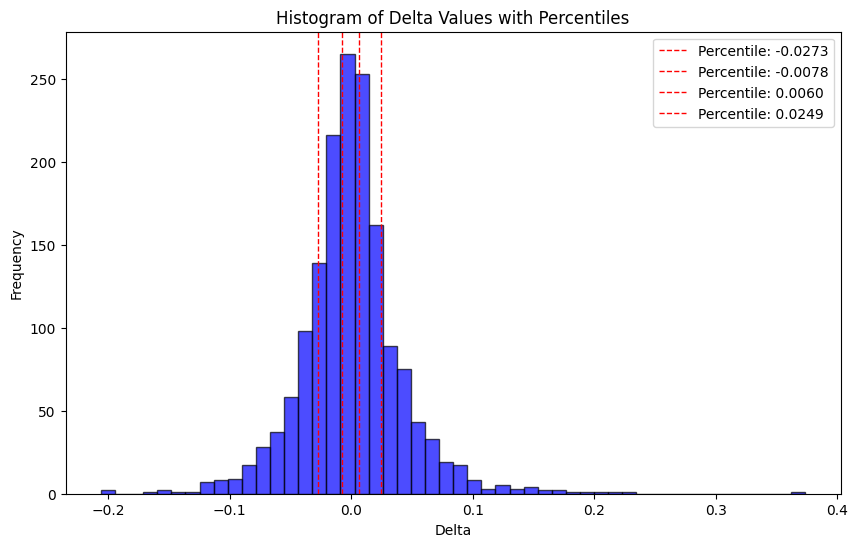

In [4]:
# Aggregate whales
whale_aggregated = whales.groupby('date').agg(
    whale_avg_valueEth=('valueETH', 'mean'),
    whale_var_valueEth=('valueETH', 'var'),
    whale_avg_gasPrice=('gasPrice', 'mean')
)

# Aggregate validators
validators_aggregated = validators.groupby('date').agg(
    validator_count=('blockHash', 'nunique'),
    validator_gas_price=('gasPrice', 'mean'),
)

print(price_deltas.head())
print(whale_aggregated.head())
print(validators_aggregated.head())

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(price_deltas['delta'].dropna(), bins=50, alpha=0.7, color='blue', edgecolor='black')
for p in percentiles:
    plt.axvline(p, color='red', linestyle='dashed', linewidth=1, label=f'Percentile: {p:.4f}')
plt.title('Histogram of Delta Values with Percentiles')
plt.xlabel('Delta')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [5]:
# Dataset merging left onto labels
_intermediate = pd.merge(
    price_deltas,
    whale_aggregated,
    on='date',
    how='left'
)

labeled_data = pd.merge(
    _intermediate,
    validators_aggregated,
    on='date',
    how='left'
)

In [6]:
labeled_data.sort_values(by='date', inplace=True, ascending=True) 
labeled_data.dropna(inplace=True)

# Split into train and test
y = labeled_data['labels'].astype(int)
X = labeled_data[['whale_avg_valueEth', 'whale_var_valueEth', 'whale_avg_gasPrice', 'validator_count', 'validator_gas_price']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# Build windows
def create_windows(data, window_size):
    windows = []
    for i in range(len(data) - window_size + 1):
        windows.append(data[i:i + window_size])
    return np.array(windows)

# Define window parameters
window_length = 14
input_features = X_train.shape[1]

# Create windowed sequences for training and testing
X_train_windowed = create_windows(X_train.values, window_length)
X_test_windowed = create_windows(X_test.values, window_length)

# Adjust labels to match windowed data (take labels that correspond to the end of each window)
y_train_windowed = y_train[window_length-1:]
y_test_windowed = y_test[window_length-1:]

In [8]:
# # Define the LSTM model
# model = Sequential([
#     Input(shape=(window_length, input_features)),
#     LSTM(64, return_sequences=True),
#     Dropout(0.5),
#     LSTM(64, return_sequences=False),
#     Dropout(0.5),
#     Dense(len(np.unique(y)), activation='softmax')  # Use unique labels count for output size
# ])

# # Compile the model
# model.compile(
#     optimizer="adam", 
#     loss="sparse_categorical_crossentropy",
#     metrics=["accuracy"]
# )

# # Train the model
# history = model.fit(
#     X_train_windowed,
#     y_train_windowed,
#     epochs=100,
#     batch_size=20,
#     validation_split=0.2,
#     verbose=0
# )

# # Evaluate the model
# test_loss, test_accuracy = model.evaluate(X_test_windowed, y_test_windowed)
# print(f"Test Accuracy: {test_accuracy}")

# # Make predictions
# y_train_pred = np.argmax(model.predict(X_train_windowed), axis=1)
# y_test_pred = np.argmax(model.predict(X_test_windowed), axis=1)

In [20]:
# Convert X_train_windowed and y_train_windowed to a DataFrame
ydf_train = pd.DataFrame(
    data=X_train_windowed.reshape(X_train_windowed.shape[0], -1),
    columns=[f"feature_{i}" for i in range(X_train_windowed.shape[1] * X_train_windowed.shape[2])]
)
ydf_train['labels'] = y_train_windowed.values

# Same for test
ydf_test = pd.DataFrame(
    data=X_test_windowed.reshape(X_test_windowed.shape[0], -1),
    columns=[f"feature_{i}" for i in range(X_test_windowed.shape[1] * X_test_windowed.shape[2])]
)
ydf_test['labels'] = y_test_windowed.values

model = ydf.RandomForestLearner(
    label= "labels",
    task=ydf.Task.CLASSIFICATION,
    num_trees=1000, # Default 300
    max_depth=8, #Default 16
    min_examples=10, #Default 5
).train(ydf_train,)

# Evaluate the model
evaluation_train = model.evaluate(ydf_train)
evaluation_test = model.evaluate(ydf_test)

y_pred_test = model.predict(ydf_test)

print(f"Train Accuracy: {evaluation_train.accuracy}")
print(f"Test Accuracy: {evaluation_test.accuracy}")
print(f"Train Confusion Matrix")
print(evaluation_train.confusion_matrix)
print(f"Test Confusion Matrix")
print(evaluation_test.confusion_matrix)

Train model on 474 examples
Model trained in 0:00:00.372794
Train Accuracy: 0.9388185654008439
Test Accuracy: 0.3119266055045872
Train Confusion Matrix
label (row) \ prediction (col)
+-----+-----+-----+-----+-----+-----+
|     |   0 |   1 |   2 |   3 |   4 |
+-----+-----+-----+-----+-----+-----+
|   0 | 127 |   0 |   0 |   0 |   0 |
+-----+-----+-----+-----+-----+-----+
|   1 |   4 |  77 |   0 |   0 |   0 |
+-----+-----+-----+-----+-----+-----+
|   2 |  14 |   0 |  57 |   0 |   0 |
+-----+-----+-----+-----+-----+-----+
|   3 |  11 |   0 |   0 |  69 |   0 |
+-----+-----+-----+-----+-----+-----+
|   4 |   0 |   0 |   0 |   0 | 115 |
+-----+-----+-----+-----+-----+-----+

Test Confusion Matrix
label (row) \ prediction (col)
+----+----+----+----+----+----+
|    |  0 |  1 |  2 |  3 |  4 |
+----+----+----+----+----+----+
|  0 | 29 |  0 |  0 |  0 |  5 |
+----+----+----+----+----+----+
|  1 | 14 |  1 |  0 |  0 |  4 |
+----+----+----+----+----+----+
|  2 | 11 |  0 |  0 |  0 |  4 |
+----+----+--

In [10]:
# model = LogisticRegression(max_iter=1000, random_state=42) ## 40% Test
# model = MLPClassifier([24, 24, 24], max_iter=10000, random_state=42, solver='adam', activation='logistic') ## 50% Test

# Fit the model on the training data
# model.fit(X_train, y_train)

# Predict on training and test data
# y_train_pred = model.predict(X_train)
# y_test_pred = model.predict(X_test)

# Calculate accuracy - FIXED to use windowed labels
# train_accuracy = accuracy_score(y_train_windowed, y_train_pred)
# test_accuracy = accuracy_score(y_test_windowed, y_test_pred)

# print(f"Train Accuracy: {train_accuracy}")
# print(f"Test Accuracy: {test_accuracy}")

# # Generate the confusion matrix - FIXED to use windowed labels
# conf_matrix = confusion_matrix(y_test_windowed, y_test_pred, labels=range(len(labels)))

# # Plot the heatmap
# plt.figure(figsize=(8, 6))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
# plt.xlabel('Predicted Labels')
# plt.ylabel('True Labels')
# plt.title('Confusion Matrix Heatmap')
# plt.show()

In [ ]:
def calculate_model_returns(predictions, price_deltas, num_labels,
                             invest_on_tie=True,  plot_results=True, investment_rate = 1.0):
    """
    Calculate expected investment returns based on model predictions and historical price changes.
    
    Parameters:
    -----------
    predictions : array-like
        Vector of model predictions (class labels).
    price_deltas : array-like
        Array of historical price changes (returns/deltas) corresponding to each prediction.
    num_labels : int
        Number of classification labels (e.g., 5 for labels 0-4).
    invest_on_tie : bool, optional, default=True
        If True, invest when the prediction is at the midpoint label (in case of ties).
    plot_results : bool, optional, default=True
        Whether to generate and display the performance plot.
    investment_rate : float, optional, default=1.0
        Proportion of capital to invest in each valid prediction.

    Returns:
    --------
    dict
        Dictionary containing the following keys:
        - 'total_return_pct': Total percentage return of the model's investment strategy.
        - 'benchmark_return_pct': Total percentage return of a buy-and-hold benchmark strategy.

    Notes:
    ------
    - The function simulates an investment strategy based on the model's predictions and compares it to a benchmark.
    - The benchmark assumes a buy-and-hold strategy with no prediction-based adjustments.
    - The function calculates and plots the capital history for both the model and the benchmark.
    """
    
    model_history = [1] # start with 1 unit of capital
    benchmark_history = [1] # Floats of unit change (-1% change is -.01)
    investing_schedule = [] # 0 = not investing, 1 = investing

    # check if investing
    def check_investment(x) -> bool:
        if num_labels <2:
            if x == 0 and invest_on_tie:
                return True
            else:
                return x > 0
        elif num_labels % 2 == 0:
            return x > num_labels // 2
        else:
            return x >= num_labels // 2 if invest_on_tie else x > num_labels // 2
        
    for i in range(len(predictions)):
        # Update benchmark history regardless of prediciton
        benchmark_history.append(model_history[-1] * (price_deltas[i] + 1))
        
        # Check if the prediction is valid for investment
        if not check_investment(predictions[i]):
            model_history.append(model_history[-1])
            
            investing_schedule.append(0)
            continue

        else:
        # Calculate the capital change based on the return value
            capital_change = model_history[-1] * price_deltas[i] * investment_rate
            new_capital = model_history[-1] + capital_change
            
            # Add to histories
            model_history.append(new_capital)
            investing_schedule.append(1)

    total_return_pct = (model_history[-1] - model_history[0]) / model_history[0] * 100
    benchmark_return_pct = (benchmark_history[-1] - benchmark_history[0]) / benchmark_history[0] * 100

    if plot_results:
        plt.figure(figsize=(12, 6))
        
        # Plot capital history
        plt.plot(model_history, label='Model', color='blue')
        plt.plot(benchmark_history, label='Benchmark', color='red')
        
        # Highlight regions where investing occurred
        for i in range(len(investing_schedule)):
            if investing_schedule[i] == 1:
                plt.axvspan(i, i + 1, color='green', alpha=0.3, label='Investing' if i == 0 else "")
        
        plt.title(f'Investment Simulation Results\n'
                  f'Model Return: {total_return_pct:.2f}%, Buy & Hold: {benchmark_return_pct:.2f}%')
        plt.xlabel('Days')
        plt.ylabel('Capital ($)')
        plt.grid(True)
        plt.legend()
        plt.show()
    
    # Return simulation results
    results = {
        'total_return_pct': total_return_pct,
        'benchmark_return_pct': benchmark_return_pct,
    } 
    
    return results

[4 4 4 4 0 0 4 0 0 4 0 0 0 0 4 0 0 0 4 0 0 0 0 0 0 0 4 0 0 0 0 0 1 4 0 0 0
 0 0 1 0 0 0 0 0 0 0 4 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 4 0 0 0 0
 0 0 0 0 4 0 4 0 0 0 0 0 0 0 4 0 0 0 0 0 4 0 0 0 0 0 0 4 0 0 0 0 0 0 0]


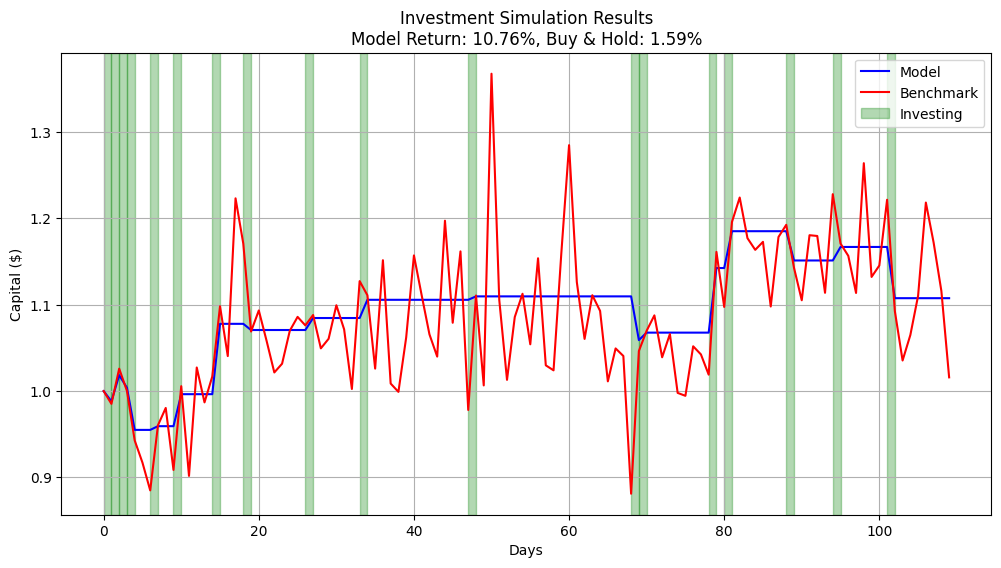

{'total_return_pct': np.float64(10.764440956303133),
 'benchmark_return_pct': np.float64(1.5920639542424286)}

In [18]:
# Get predictions from the model
predictions = np.argmax(model.predict(ydf_test), axis=1)
print(predictions)

# Extract the 'delta' column from price_deltas for the corresponding test data
price_deltas_test = price_deltas['delta'].iloc[-len(y_test_windowed):].to_numpy()

# Calculate model returns
calculate_model_returns(predictions=predictions, price_deltas=price_deltas_test, num_labels=num_labels,invest_on_tie=False, investment_rate=0.8)